In [1]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse, urljoin
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import List, Dict, Optional

def analyze_url(url: str) -> Optional[Dict]:
    """
    Analyzes the given URL to determine:
    1. Whether it contains external links.
    2. The number of external links.
    3. The number of internal links.
    4. The number of images.

    Parameters:
    - url (str): The URL of the web page to analyze.

    Returns:
    - dict: A dictionary containing the analysis results if successful.
    - None: If there was an error fetching or processing the URL.
    """
    try:
        # Send HTTP GET request to the URL
        response = requests.get(url, timeout=10)
        response.raise_for_status()  # Raise HTTPError for bad responses

        # Parse the HTML content
        soup = BeautifulSoup(response.text, 'html.parser')

        # Get the base domain
        parsed_url = urlparse(url)
        base_domain = parsed_url.netloc

        # Initialize counters
        external_links = set()
        internal_links = set()
        images = set()

        # Extract all <a> tags with href attributes
        for link in soup.find_all('a', href=True):
            href = link['href']
            # Resolve relative URLs
            absolute_href = urljoin(url, href)
            href_parsed = urlparse(absolute_href)
            href_domain = href_parsed.netloc

            if href_domain and href_domain != base_domain:
                external_links.add(absolute_href)
            elif href_domain == base_domain or not href_domain:
                internal_links.add(absolute_href)

        # Extract all <img> tags with src attributes
        for img in soup.find_all('img', src=True):
            src = img['src']
            absolute_src = urljoin(url, src)
            images.add(absolute_src)

        # Determine if there are external links
        is_multipage = len(external_links) + len(internal_links) > 0

        return {
            "url": url,
            "is_multipage": int(is_multipage),
            "external_links_count": len(external_links),
            "internal_links_count": len(internal_links),
            "images_count": len(images)
        }

    except requests.exceptions.RequestException as e:
        print(f"Error fetching the URL '{url}': {e}")
        return None

def process_urls(url_list: List[str], max_results: int = 300, max_workers: int = 20) -> pd.DataFrame:
    """
    Processes a list of URLs concurrently, analyzes each valid URL, and collects statistics.

    Parameters:
    - url_list (List[str]): A list of URLs to process.
    - max_results (int): The maximum number of valid URL statistics to collect. Default is 300.
    - max_workers (int): The number of threads to use for concurrent processing. Default is 20.

    Returns:
    - pd.DataFrame: A DataFrame containing the statistics of the processed URLs.
    """
    results = []
    processed = 0
    total_urls = len(url_list)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all URL analysis tasks
        future_to_url = {executor.submit(analyze_url, url): url for url in url_list}

        for future in as_completed(future_to_url):
            url = future_to_url[future]
            try:
                result = future.result()
                if result is not None:
                    results.append(result)
                    processed += 1
                    print(f"Processed {processed}/{max_results}: {url}")
                else:
                    print(f"Skipped invalid URL: {url}")

                if processed >= max_results:
                    print(f"Reached the target of {max_results} valid URLs.")
                    break

            except Exception as exc:
                print(f"URL generated an exception: {url}, {exc}")

    # Create DataFrame
    df = pd.DataFrame(results, columns=[
        "url",
        "is_multipage",
        "external_links_count",
        "internal_links_count",
        "images_count"
    ])

    return df



# count page statistics

In [ ]:
# Example Usage

# Example list of URLs (replace with your actual URLs)
url_list = ["https://" + x for x in pd.read_csv("tranco.csv", header=None)[1].tolist()]

# Process the URLs
df_statistics = process_urls(url_list, max_results=300, max_workers=30)

# Optionally, display the DataFrame
print(df_statistics.head())
df_statistics.to_csv("url_statistics.csv", index=False)


In [2]:
import pandas as pd
url_data = pd.read_csv("url_statistics.csv")
multipage = url_data[url_data["is_multipage"] == 1]
multipage.describe()



,is_multipage,external_links_count,internal_links_count,images_count
count,271.0,271.000000,271.000000,271.000000
mean,1.0,56.623616,49.752768,27.129151
std,0.0,73.785314,77.884778,44.417901
min,1.0,0.000000,0.000000,0.000000
25%,1.0,13.000000,4.000000,3.000000
50%,1.0,26.000000,22.000000,14.000000
75%,1.0,76.000000,72.000000,37.500000
max,1.0,361.000000,763.000000,537.000000


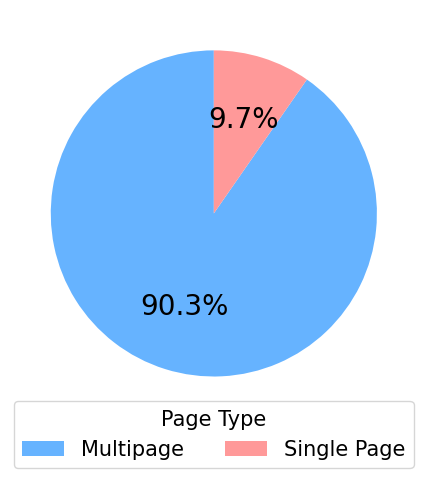

In [72]:
# Re-importing necessary library and generating the required visualizations and summary statistics
import matplotlib.pyplot as plt
url_data = pd.read_csv("url_statistics.csv")

# Pie chart for 'is_multipage'
is_multipage_counts = url_data['is_multipage'].value_counts()

plt.figure(figsize=(5, 5))
plt.rcParams.update({'font.size': 20})
# light colors
colors = ['#66b3ff', '#ff9999',]
plt.pie(is_multipage_counts, autopct='%1.1f%%', startangle=90, colors=colors)
# the legend is added to the lower center of the plot and is horizontally aligned
plt.rcParams.update({'font.size': 15})
plt.legend(loc='lower center', labels=['Multipage', 'Single Page'], title='Page Type', ncol=2, bbox_to_anchor=(0.5, -0.15))

plt.tight_layout()
plt.savefig('is_multipage_pie_chart.pdf')
plt.show()

C:\Users\22476\AppData\Local\Temp\ipykernel_7836\1579696236.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['binned_pie'] = pd.cut(df_cleaned['Internal Links Count'], bins=bins_pie, right=False, labels=bin_labels_pie)


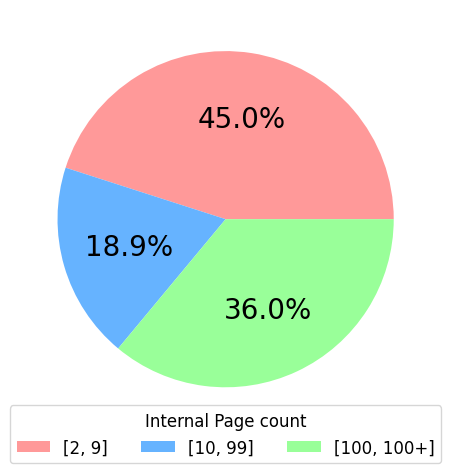

In [76]:

import matplotlib.pyplot as plt

df = pd.read_csv("internal_links_count.csv")
# Dropping entries with no count (NaN values in the 'Internal Links Count' column)
df_cleaned = df.dropna(subset=['Internal Links Count'])


# Adjust the binning to have the categories 0-5, 5-99, and 100+
bins_pie = [0, 9, 100, float('inf')]
bin_labels_pie = ['[2, 9]', '[10, 99]', '[100, 100+]']

# Apply the new bins for the pie chart
df_cleaned['binned_pie'] = pd.cut(df_cleaned['Internal Links Count'], bins=bins_pie, right=False, labels=bin_labels_pie)

# Create a pie chart
plt.figure(figsize=(5, 5))
plt.rcParams.update({'font.size': 20})
# light colors
colors = ['#ff9999','#66b3ff','#99ff99']
df_cleaned['binned_pie'].value_counts().sort_index().plot(kind='pie', autopct='%1.1f%%', labels=None, colors=colors)
plt.ylabel('')  # Remove y-label for better appearance
# font size of the legend is set to 12
plt.rcParams.update({'font.size': 12})
plt.legend(loc='lower center', labels=bin_labels_pie, title='Internal Page count', ncol=3, bbox_to_anchor=(0.5, -0.1))
plt.tight_layout()
plt.savefig('internal_page_pie_chart.pdf')
plt.show()


# count internal pages

In [5]:
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from bs4 import BeautifulSoup
from urllib.parse import urlparse, urljoin
import time

def get_internal_links(soup, base_url):
    """Extract all internal links from the HTML content."""
    parsed_base_url = urlparse(base_url)
    base_domain = f"{parsed_base_url.scheme}://{parsed_base_url.netloc}"
    internal_links = set()

    for a_tag in soup.find_all("a", href=True):
        href = a_tag['href']
        href_parsed = urlparse(href)
        
        if href.startswith("/"):  # relative link
            full_url = urljoin(base_domain, href)
            internal_links.add(full_url)
        elif href_parsed.netloc == parsed_base_url.netloc:  # same domain
            internal_links.add(href)
    
    return internal_links

def crawl_url(start_url, max_distinct_links=500, result_dict=None):
    visited_links = set()  # All links that have been visited
    to_visit = set([start_url,])  # Queue of links to visit

    # Firefox options (headless for faster operation)
    options = Options()
    options.headless = True
    driver = webdriver.Firefox(options=options)

    while to_visit and len(visited_links) < max_distinct_links:
        current_url = to_visit.pop()

        if current_url in visited_links:
            continue

        try:
            driver.get(current_url)
            # time.sleep(2)  # Let the page load
            soup = BeautifulSoup(driver.page_source, 'html.parser')
        except Exception as e:
            print(f"Error visiting {current_url}: {e}")
            continue

        # Get internal links from the current page
        internal_links = get_internal_links(soup, current_url)


        # Add new links to the 'to_visit' queue, avoiding already visited ones
        new_links = internal_links - visited_links
        to_visit.update(new_links)

        # Add the current URL to the visited set
        visited_links.add(current_url)

    driver.quit()
    # return the number of unique internal links visited
    result_dict[start_url] = len(visited_links) if len(visited_links) else None

# Example usage:
if __name__ == "__main__":
    from tqdm.auto import tqdm
    import threading
    import pandas as pd
    input_urls = ["https://" + x for x in pd.read_csv("tranco.csv", header=None)[1].tolist()]
    
    result = {url: None for url in input_urls}
    p_list = []
    for url in tqdm(input_urls):
        # print(f"Processing URL: {url}")
        # result[url] = crawl_url(url, 500, result)
        p = threading.Thread(target=crawl_url, args=(url, 100, result))
        p.start()
        p_list.append(p)
        if len(p_list) >= 20:
            for p in p_list:
                p.join()
            p_list = []
               # save result to a csv file
            pd.DataFrame(result.items(), columns=["URL", "Internal Links Count"]).to_csv("internal_links_count.csv", index=False)
        
        # if number of not Nones in result is greater than 5, break
        if len([x for x in result.values() if x is not None]) >= 100:
            break
    for p in p_list:
        p.join()

    # save result to a csv file
    pd.DataFrame(result.items(), columns=["URL", "Internal Links Count"]).to_csv("internal_links_count.csv", index=False)

  0%|          | 0/600 [00:00<?, ?it/s]

The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.2.591); currently, geckodriver 0.35.0 is recommended for firefox 129.*, so it is advised to delete the driver in PATH and retry
The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.2.591); currently, geckodriver 0.35.0 is recommended for firefox 129.*, so it is advised to delete the driver in PATH and retry
The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.2.591); currently, geckodriver 0.35.0 is recommended for firefox 129.*, so it is advised to delete the driver in PATH and retry
The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.

Error visiting https://a-msedge.net: Message: Reached error page: about:neterror?e=dnsNotFound&u=https%3A//a-msedge.net/&c=UTF-8&d=We%20can%E2%80%99t%20connect%20to%20the%20server%20at%20a-msedge.net.
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:193:5
UnknownError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:832:5
checkReadyState@chrome://remote/content/marionette/navigate.sys.mjs:58:24
onNavigation@chrome://remote/content/marionette/navigate.sys.mjs:343:39
emit@resource://gre/modules/EventEmitter.sys.mjs:148:20
receiveMessage@chrome://remote/content/marionette/actors/MarionetteEventsParent.sys.mjs:33:25

Error visiting https://amazonaws.com: Message: Reached error page: about:neterror?e=connectionFailure&u=https%3A//amazonaws.com/&c=UTF-8&d=Firefox%20can%E2%80%99t%20establish%20a%20connection%20to%20the%20server%20at%20amazonaws.com.
Stacktrace:
RemoteError@chrome://remo

The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.2.591); currently, geckodriver 0.35.0 is recommended for firefox 129.*, so it is advised to delete the driver in PATH and retry
The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.2.591); currently, geckodriver 0.35.0 is recommended for firefox 129.*, so it is advised to delete the driver in PATH and retry
The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.2.591); currently, geckodriver 0.35.0 is recommended for firefox 129.*, so it is advised to delete the driver in PATH and retry
The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.

Error visiting https://akadns.net: Message: Reached error page: about:neterror?e=dnsNotFound&u=https%3A//akadns.net/&c=UTF-8&d=We%20can%E2%80%99t%20connect%20to%20the%20server%20at%20akadns.net.
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:193:5
UnknownError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:832:5
checkReadyState@chrome://remote/content/marionette/navigate.sys.mjs:58:24
onNavigation@chrome://remote/content/marionette/navigate.sys.mjs:343:39
emit@resource://gre/modules/EventEmitter.sys.mjs:148:20
receiveMessage@chrome://remote/content/marionette/actors/MarionetteEventsParent.sys.mjs:33:25

Error visiting https://tiktokcdn.com: Message: Reached error page: about:neterror?e=dnsNotFound&u=https%3A//tiktokcdn.com/&c=UTF-8&d=We%20can%E2%80%99t%20connect%20to%20the%20server%20at%20tiktokcdn.com.
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mj

The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.2.591); currently, geckodriver 0.35.0 is recommended for firefox 129.*, so it is advised to delete the driver in PATH and retry
The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.2.591); currently, geckodriver 0.35.0 is recommended for firefox 129.*, so it is advised to delete the driver in PATH and retry
The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.2.591); currently, geckodriver 0.35.0 is recommended for firefox 129.*, so it is advised to delete the driver in PATH and retry
The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.

Error visiting https://aaplimg.com: Message: Reached error page: about:neterror?e=dnsNotFound&u=https%3A//aaplimg.com/&c=UTF-8&d=We%20can%E2%80%99t%20connect%20to%20the%20server%20at%20aaplimg.com.
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:193:5
UnknownError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:832:5
checkReadyState@chrome://remote/content/marionette/navigate.sys.mjs:58:24
onNavigation@chrome://remote/content/marionette/navigate.sys.mjs:343:39
emit@resource://gre/modules/EventEmitter.sys.mjs:148:20
receiveMessage@chrome://remote/content/marionette/actors/MarionetteEventsParent.sys.mjs:33:25

Error visiting https://domaincontrol.com: Message: Reached error page: about:neterror?e=connectionFailure&u=https%3A//domaincontrol.com/&c=UTF-8&d=Firefox%20can%E2%80%99t%20establish%20a%20connection%20to%20the%20server%20at%20domaincontrol.com.
Stacktrace:
RemoteError@chro

The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.2.591); currently, geckodriver 0.35.0 is recommended for firefox 129.*, so it is advised to delete the driver in PATH and retry
The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.2.591); currently, geckodriver 0.35.0 is recommended for firefox 129.*, so it is advised to delete the driver in PATH and retry
The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.2.591); currently, geckodriver 0.35.0 is recommended for firefox 129.*, so it is advised to delete the driver in PATH and retry
The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.

Error visiting https://wac-msedge.net: Message: Reached error page: about:neterror?e=dnsNotFound&u=https%3A//wac-msedge.net/&c=UTF-8&d=We%20can%E2%80%99t%20connect%20to%20the%20server%20at%20wac-msedge.net.
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:193:5
UnknownError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:832:5
checkReadyState@chrome://remote/content/marionette/navigate.sys.mjs:58:24
onNavigation@chrome://remote/content/marionette/navigate.sys.mjs:343:39
emit@resource://gre/modules/EventEmitter.sys.mjs:148:20
receiveMessage@chrome://remote/content/marionette/actors/MarionetteEventsParent.sys.mjs:33:25

Error visiting https://gvt1.com: Message: Reached error page: about:neterror?e=dnsNotFound&u=https%3A//gvt1.com/&c=UTF-8&d=We%20can%E2%80%99t%20connect%20to%20the%20server%20at%20gvt1.com.
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8

The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.2.591); currently, geckodriver 0.35.0 is recommended for firefox 129.*, so it is advised to delete the driver in PATH and retry
The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.2.591); currently, geckodriver 0.35.0 is recommended for firefox 129.*, so it is advised to delete the driver in PATH and retry
The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.2.591); currently, geckodriver 0.35.0 is recommended for firefox 129.*, so it is advised to delete the driver in PATH and retry
The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.

Error visiting https://ytimg.com: Message: Reached error page: about:neterror?e=dnsNotFound&u=https%3A//ytimg.com/&c=UTF-8&d=We%20can%E2%80%99t%20connect%20to%20the%20server%20at%20ytimg.com.
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:193:5
UnknownError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:832:5
checkReadyState@chrome://remote/content/marionette/navigate.sys.mjs:58:24
onNavigation@chrome://remote/content/marionette/navigate.sys.mjs:343:39
emit@resource://gre/modules/EventEmitter.sys.mjs:148:20
receiveMessage@chrome://remote/content/marionette/actors/MarionetteEventsParent.sys.mjs:33:25

Error visiting https://cdninstagram.com: Message: Reached error page: about:neterror?e=dnsNotFound&u=https%3A//cdninstagram.com/&c=UTF-8&d=We%20can%E2%80%99t%20connect%20to%20the%20server%20at%20cdninstagram.com.
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.

The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.2.591); currently, geckodriver 0.35.0 is recommended for firefox 129.*, so it is advised to delete the driver in PATH and retry
The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.2.591); currently, geckodriver 0.35.0 is recommended for firefox 129.*, so it is advised to delete the driver in PATH and retry
The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.2.591); currently, geckodriver 0.35.0 is recommended for firefox 129.*, so it is advised to delete the driver in PATH and retry
The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.

Error visiting https://bytefcdn-ttpeu.com: Message: Reached error page: about:neterror?e=dnsNotFound&u=https%3A//bytefcdn-ttpeu.com/&c=UTF-8&d=We%20can%E2%80%99t%20connect%20to%20the%20server%20at%20bytefcdn-ttpeu.com.
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:193:5
UnknownError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:832:5
checkReadyState@chrome://remote/content/marionette/navigate.sys.mjs:58:24
onNavigation@chrome://remote/content/marionette/navigate.sys.mjs:343:39
emit@resource://gre/modules/EventEmitter.sys.mjs:148:20
receiveMessage@chrome://remote/content/marionette/actors/MarionetteEventsParent.sys.mjs:33:25

Error visiting https://a2z.com: Message: Reached error page: about:neterror?e=dnsNotFound&u=https%3A//a2z.com/&c=UTF-8&d=We%20can%E2%80%99t%20connect%20to%20the%20server%20at%20a2z.com.
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.

The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.2.591); currently, geckodriver 0.35.0 is recommended for firefox 129.*, so it is advised to delete the driver in PATH and retry
The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.2.591); currently, geckodriver 0.35.0 is recommended for firefox 129.*, so it is advised to delete the driver in PATH and retry
The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.2.591); currently, geckodriver 0.35.0 is recommended for firefox 129.*, so it is advised to delete the driver in PATH and retry
The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.

Error visiting https://aiv-cdn.net: Message: Reached error page: about:neterror?e=dnsNotFound&u=https%3A//aiv-cdn.net/&c=UTF-8&d=We%20can%E2%80%99t%20connect%20to%20the%20server%20at%20aiv-cdn.net.
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:193:5
UnknownError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:832:5
checkReadyState@chrome://remote/content/marionette/navigate.sys.mjs:58:24
onNavigation@chrome://remote/content/marionette/navigate.sys.mjs:343:39
emit@resource://gre/modules/EventEmitter.sys.mjs:148:20
receiveMessage@chrome://remote/content/marionette/actors/MarionetteEventsParent.sys.mjs:33:25

Error visiting https://ttlivecdn.com: Message: Reached error page: about:neterror?e=dnsNotFound&u=https%3A//ttlivecdn.com/&c=UTF-8&d=We%20can%E2%80%99t%20connect%20to%20the%20server%20at%20ttlivecdn.com.
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys

The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.2.591); currently, geckodriver 0.35.0 is recommended for firefox 129.*, so it is advised to delete the driver in PATH and retry
The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.2.591); currently, geckodriver 0.35.0 is recommended for firefox 129.*, so it is advised to delete the driver in PATH and retry
The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.2.591); currently, geckodriver 0.35.0 is recommended for firefox 129.*, so it is advised to delete the driver in PATH and retry
The geckodriver version (0.34.0) detected in PATH at C:\Users\Tony\utils\geckodriver.exe might not be compatible with the detected firefox version (129.0.

Error visiting https://adnxs.com: Message: Reached error page: about:neterror?e=dnsNotFound&u=https%3A//adnxs.com/&c=UTF-8&d=We%20can%E2%80%99t%20connect%20to%20the%20server%20at%20adnxs.com.
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:193:5
UnknownError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:832:5
checkReadyState@chrome://remote/content/marionette/navigate.sys.mjs:58:24
onNavigation@chrome://remote/content/marionette/navigate.sys.mjs:343:39
emit@resource://gre/modules/EventEmitter.sys.mjs:148:20
receiveMessage@chrome://remote/content/marionette/actors/MarionetteEventsParent.sys.mjs:33:25

Error visiting https://b-msedge.net: Message: Reached error page: about:neterror?e=dnsNotFound&u=https%3A//b-msedge.net/&c=UTF-8&d=We%20can%E2%80%99t%20connect%20to%20the%20server%20at%20b-msedge.net.
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
